# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2025

Druet, Yann, 2198643

Provost-Cardin, Alexandre, 2210084

Note finale :

 <u>**Date limite de remise :**</u>  18 mars 23h59 (Groupe B1), 11 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez vous inspirer de code trouvé sur Internet, tant que vous en mentionnez la source, mais vous devez créer votre propre implémentation, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Dans ce TP, vous allez travailler sur le problème de faire de la monnaie. La première partie du problème est définie avec une liste de taille `size` de différents nombres naturels qui représentent les pièces de monnaie que vous avez à votre disposition. Il faut ensuite définir le `total` que vous voulez faire avec les pièces à votre disposition. La difficulté est qu'il faut le faire avec le moins de pièces possibles.

Par exemple :
- `size = 3`, `total = 19`
- Vos pièces sont : `[1,4,9]`
- La solution optimale est : `[9,9,1]`

**IMPORTANT** Le ratio entre `size` et `total` affecte fortement le taux de succès. Plus `size` s'approche de `total`, plus le problème devient facile. Avec un petit test (donc les valeurs ne sont pas parfaites), on estime qu'à un ratio de 60%, le problème devient trivial. Même à un ratio de 35%, on observe une augmentation visible dans le taux de succès. Pour contrer ce problème, essayez de choisir des valeurs pour le `total` qui sont un ordre de magnitude de plus que `size` (10 fois plus).

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme diviser pour régner sans mémoization
3. Un algorithme de programmation dynamique


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une liste d'une taille donnée contenant les pièces de monnaie différentes disponibles pour résoudre le problème. Tous les exemplaires contiennent la valeur `1` et devrait avoir une solution.

In [9]:
import random
from collections.abc import Iterable, Callable

class Problem():
    def __init__(
        self,
        size: int, 
        total: int, 
        num_samples: int = 5
    ) -> None:
        self.num_samples: int = num_samples
        self.size: int = size
        self.total: int = total

    def generate_sample(self) -> list[int]:
        """Returns a list of given size containing the different denominations to be used"""
        instance = list(range(2, self.total))
        random.shuffle(instance)
        instance = instance[:self.size-1]
        instance.append(1)
        return instance

    def generate_dataset(self) -> Iterable[list[int]]:
        """Returns an iterator over as many samples as are described """
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude de vos algorithmes, mesurer leur performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et de comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [2]:
import time
import warnings
import matplotlib.pyplot as plt
from scipy.stats import linregress


class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")


class InvalidProblem(Exception):
    def __init__(self, message: str):
        super().__init__(f"Invalid problem. {message}")


class Measure():
    """A wrapper to contain information on taken measures. mae is Mean Absolute Error"""
    def __init__(self, size: int, total: int, mean_time: float, correct_frac:float, mean_error:float) -> None:
        """Args:
            mae (float): Mean Absolute Error
        """
        self.size = size
        self.total = total
        self.mean_time = mean_time
        self.correct_frac = correct_frac
        self.mean_error = mean_error


def make_problems(
    sizes: list[int],
    totals: list[int],
    num_samples: int = 5
) -> list[Problem]:
    """Creates problem instances using given sizes and total value"""
    problems: list[Problem] = []
    for size in sizes:
        for total in totals:
            if size > total:
                raise InvalidProblem("Size is greater than total which results in a trivial problem")
            elif size >= total/2:
                warnings.warn("Avoid setting a size that is close to half the total, it simplifies the problem")
            problems.append(Problem(size,total,num_samples))
    return problems


def recursive_memoization(a,b,c,d):
    if b == 0:
        return 0
    if b < 0 or a == len(c):
        return float('inf')
    if d[a][b] != -1:
        return d[a][b] 
    e = float('inf')
    if c[a] > 0:
        e = recursive_memoization(a, b - c[a], c, d)
        if e != float('inf'):
            e += 1
    f = recursive_memoization(a + 1, b, c, d)
    d[a][b] = min(e, f)
    return d[a][b]


def get_error(sample: list[int], total: int, solution: list[int]) -> int:
    """Returns the difference between the given solution and the minimum possible"""
    return len(solution) - recursive_memoization(0,total,sample,[[-1]*(total+1) for _ in range(len(sample))])


def verify_solution(sample: list[int], total: int, solution: list[int]) -> bool:
    """Validates if the solution is correct. This does not guarantee an optimal solution"""
    
    # The solution must reach the desired target
    if sum(solution) != total:
        return False

    sample_set = set(sample)
    # All values in the solution must be options in the sample
    if any(iter not in sample_set for iter in solution):
        return False

    # Solution is valid
    return True


def measure(
    procedure: Callable[[list[int],int],list[int]],
    sample: list[int],
    total: int,
    time_scale: int = 1000
) -> tuple[int,int]:
    """Returns the time in milliseconds taken to run the procedure as well as the absolute error in a tuple.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample.copy(),total)
    end: int = time.time() * time_scale
    if not verify_solution(sample, total, solution):
        raise InvalidSolution()
    return (round(end - start), get_error(sample,total,solution))


def measure_mean(procedure: Callable[[list[int],int],list[int]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    measures = [measure(procedure,sample,prob.total,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(iter[0] for iter in measures) / prob.num_samples
    n = len(measures)
    n_correct = len([iter for iter in measures if iter[1] == 0])
    correct_frac = n_correct / n
    mean_error = 0
    if n_correct != n:
        mean_error = sum(iter[1] for iter in measures) / (n - n_correct)
    return Measure(prob.size, prob.total, mean_time, correct_frac, mean_error)


def measure_range(procedure: Callable[[list[int],int],list[int]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]


def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <20} {: <20} {: <20} {: <20} {: <20}".format("Taille","Somme","Temps moyen (ms)", "Taux de succès", "Erreur moyenne"))
    for measure in measures:
        print("{: <20} {: <20} {: <20} {: <20} {: <20}".format(measure.size, measure.total, measure.mean_time, measure.correct_frac, round(measure.mean_error, 3)))


### The different tests are below, the names are in french to avoid confusion


def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()


def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton (5 points)

<u>**Question 1 :**</u> Implantez un algorithme suivant le patron de conception glouton.

Il est normal que le glouton ne retourne pas toujours la solution optimale. Vous pouvez voir l'erreur obtenue, soit le nombre de pièces de plus que la solution optimale, et le taux de réponse optimal avec les fonctions de mesure.

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

In [3]:
size = 5
total = size * 10
problem = Problem(size, total)
sample = problem.generate_sample()
# print(sample)

def Glouton(coins: list[int], total: int):
    coins.sort()
    # print(coins)
    isSolutionFind = False
    i: int = len(coins) - 1
    coinsSolution: list[int] = []
    reste = total
    while(not isSolutionFind):
        if reste == 0:
            break
        selectedCoins = coins[i]
        if selectedCoins > reste:
            i = i - 1
            continue
        if reste ==  0:
            isSolutionFind = True
        reste = reste - selectedCoins
        coinsSolution.append(selectedCoins)
    return coinsSolution

print(Glouton(sample, total))

[42, 1, 1, 1, 1, 1, 1, 1, 1]


### Analyse asymptotique

<u>**Question 2 :**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

*Insérer votre réponse ici*

### Mesures

<u>**Question 3 :**</u> Rapportez dans un tableau les temps d'exécution moyens avec les fonctions auxiliaires `measure_range` et `display_data_as_table`.

### Validation empirique

<u>**Question 4 :**</u> Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix effectués.

*Insérer votre réponse ici*

## Partie 2 : Algorithme diviser pour régner (5 points)

Utilisez le patron de conception diviser pour régner pour cet algorithme. Vous devriez être capable de trouver un algorithme qui retourne uniquement les solutions optimales même sans mémoïsation. Pour ce faire, vous devriez comparer l'impact qu'aurait d'ajouter une pièce par rapport à la passer pour obtenir la somme souhaitée.

<u>**Question 1 :**</u> Implantez l'algorithme suivant le patron diviser pour régner.

In [4]:
def FindBestSubSolution(solutions: list[int]):
    smallestSolution = []
    if solutions == None:
        return None
    
    for solution in solutions:
        if solution == solutions[0]:
            smallestSolution = solution
    
        if len(solution) < len(smallestSolution):
            smallestSolution = solution

    return smallestSolution

def DivideAndConquer(coins:list[int], total: int) -> list[int]:
    solutions: list[list[int]] = []
    if total <= 0:
        return
    for coin in coins:
        solution = []
        delta = total - coin
        if delta < 0:
            continue
        solution.append(coin)
        solutions.append(solution)
        restOfSolution = DivideAndConquer(coins, delta)
        if restOfSolution != None:
            solution.extend(restOfSolution)
            
    return FindBestSubSolution(solutions)


print(sample, total)
print(DivideAndConquer(sample, total))


[1, 10, 30, 37, 42] 50
[10, 10, 30]


### Analyse asymptotique

<u>**Question 2 :**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

Premièrement, la fonction FindBestSubSolution suit une complexité O(m) où m est le nombre de solutions. La fonction recursive DivideAndConquer itère à travers toutes les pièces de monnaie, qu'on peut représenter par k. Ensuite, pour chaque appel récursif, la fonction essaie de soustraire chaque pièce de la valeur total, ce qui génère k appels récursifs dans le pire cas. La profondeur maximale de récursion est proportionnelle à total, soit O(n) avec n = total. On peut représenter la récurrence de la fonction DivideAndConquer comme ceci:

f(n) = k * f(n - 1) + O(m)

Si on développe jusqu'à f(0), on obtient

f(n) = k * (k * f(n - 2) + O(m)) + O(m) = k^2 * f(n - 2) + O(m)

f(n) = k^3 * f(n - 3) + k^2 * O(m) + k * O(m) + O(m)

...

k^n * f(0) + ∑k^i * O(m)

La complexité temporelle est donc O(k^n).

### Mesures

<u>**Question 3 :**</u> Rapportez dans un tableau les temps d'exécution moyens avec les fonctions auxiliaires `measure_range` et `display_data_as_table` **C'est attendu que cet algorithme soit beaucoup plus lent que le glouton. Vous n'avez pas besoin de mesurer sur des exemplaires aussi gros.**

In [52]:
measures_divide_and_conquer = measure_range(DivideAndConquer, make_problems([2], range(10, 31, 1), num_samples=200), 1e6)
display_data_as_table(measures_divide_and_conquer)

Taille               Somme                Temps moyen (ms)     Taux de succès       Erreur moyenne      
2                    10                   28.27                1.0                  0                   
2                    11                   34.555               1.0                  0                   
2                    12                   46.09                1.0                  0                   
2                    13                   50.15                1.0                  0                   
2                    14                   91.595               1.0                  0                   
2                    15                   104.27               1.0                  0                   
2                    16                   209.925              1.0                  0                   
2                    17                   263.205              1.0                  0                   
2                    18                   367.12       

### Validation empirique

<u>**Question 4 :**</u> Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix effectués.

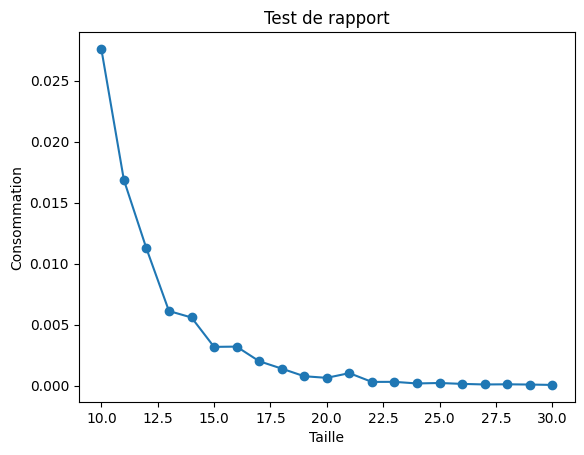

In [ ]:
measures_divide_and_conquer_dict: dict[int: int] = {}
for m in measures_divide_and_conquer:
    measures_divide_and_conquer_dict[m.total] = m.mean_time / (m.size ** m.total) # f(x) = k^x
test_de_rapport(measures_divide_and_conquer_dict, "Taille", "Consommation")

Nous avons choisi d'utiliser le test de rapport. Nous avons déjà une idée de la consommation de temps de notre algorithme. Elle croit selon f(x) =  k^x. Le test de rapport nous permet de confirmer que la croissance suit réellement la fonction f(x) = k^x. Comme nous pouvons le voir ci-dessus, les valeurs dans notre test du rapport semblent converger vers 0, ce qui voudrait dire que notre hypothèse est une sur-estimation. Notre algorithme suivrait donc une consommation de temps plus petite que O(k^n).

## Partie 3 : Algorithme de programmation dynamique (5 points)

Vous pouvez trouvez une bonne présentation de cet algorithme dans les capsules vidéos du cours.

<u>**Question 1 :**</u> Implantez l'algorithme de programmation dynamique.

In [ ]:
def DynamicProgramming(coins: list[int], total: int) -> list[int]:
    c = [float('inf')] * (total + 1)
    c[0] = 0
    choix = [-1] * (total + 1)
    
    for montant in range(1, total + 1):
        for i, coin in enumerate(coins):
            if montant >= coin and c[montant - coin] + 1 < c[montant]:
                c[montant] = c[montant - coin] + 1
                choix[montant] = i

    if c[total] == float('inf'):
        return []

    solution = []
    montant = total
    while montant > 0:
        piece = coins[choix[montant]]
        solution.append(piece)
        montant -= piece

    return solution

coins = [1, 4, 9]
total = 19
print(DynamicProgramming(coins, total))


[1, 9, 9]


### Analyse asymptotique

<u>**Question 2 :**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

Cet algorithme contient deux boucles imbriquées. La première boucle parcourt tous les montants possibles de 1 jusqu'à total. Cette boucle suit donc la complexité O(k) où k = total. La deuxième boucle est imbriquée dans la première et teste chaque pièce disponible. Sa complexité est donc O(n) où n est la nombre de pièces. La complexité globale de l'algorithme est donc O(k * n). 

### Mesures

<u>**Question 3 :**</u> Rapportez dans un tableau les temps d'exécution moyens avec les fonctions auxiliaires `measure_range` et `display_data_as_table`.

In [93]:
measures_dynamic_programming = measure_range(DynamicProgramming, make_problems([2, 3, 4], range(10, 200, 10), num_samples=2000), 1e6)
display_data_as_table(measures_dynamic_programming)

Taille               Somme                Temps moyen (ms)     Taux de succès       Erreur moyenne      
2                    10                   4.546                1.0                  0                   
2                    20                   8.101                1.0                  0                   
2                    30                   9.9235               1.0                  0                   
2                    40                   12.832               1.0                  0                   
2                    50                   15.663               1.0                  0                   
2                    60                   18.232               1.0                  0                   
2                    70                   22.1955              1.0                  0                   
2                    80                   24.1315              1.0                  0                   
2                    90                   26.8695      

### Validation empirique

<u>**Question 4 :**</u> Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre.  Justifiez les choix effectués.

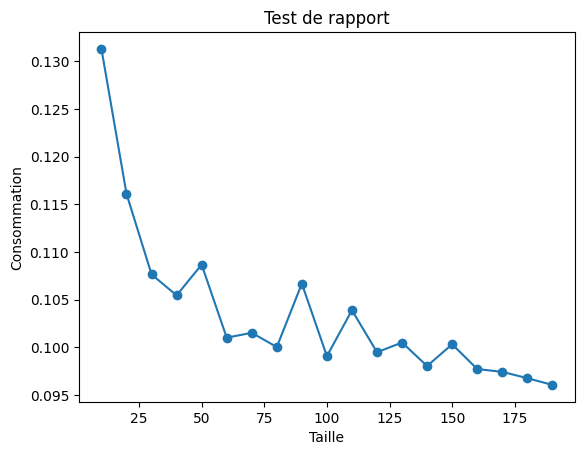

In [95]:
measures_dynamic_programming_dict: dict[int: int] = {}
for m in measures_dynamic_programming:
    measures_dynamic_programming_dict[m.total] = m.mean_time / (m.size * m.total) # f(x) = k*x
test_de_rapport(measures_dynamic_programming_dict, "Taille", "Consommation")

Nous avons choisi d'utiliser le test de rapport. Nous avons déjà une idée de la consommation de temps de notre algorithme. Elle croit selon f(x) =  k*x. Le test de rapport nous permet de confirmer que la croissance suit réellement la fonction f(x). Comme nous pouvons le voir ci-dessus, les valeurs dans notre test du rapport semblent converger une constante qui n'est pas 0 (entre 0.095 et 0.100). Cela veut dire que notre hypothèse est confirmée et que notre algorithme suit une croissance selon f(x).

# Évaluation de la consommation énergétique (1 point)

Dans le cadre de ce TP, nous voulons vous sensibiliser à la consommation énergétique de vos algorithmes. Pour ce faire, nous vous fournissons une librairie que vous pouvez utiliser pour évaluer l'énergie nécessaire à la complétion de votre algorithme (https://mlco2.github.io/codecarbon/). Appelez chacun de vos algorithmes ci-bas avec les mêmes exemplaires et comparez le résultat obtenu par chacun.

In [6]:
#Commande pour installer la librairie
#!pip install codecarbon

In [8]:
from codecarbon import EmissionsTracker
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("glouton")
    # TODO Appel glouton
    tracker.stop_task()

    tracker.start_task("diviser")
    # TODO Appel diviser pour régner
    tracker.stop_task()

    tracker.start_task("dynamique")
    # TODO Appel dynamique
    tracker.stop_task()
finally:
    _ = tracker.stop()

[codecarbon INFO @ 20:12:15] [setup] RAM Tracking...
[codecarbon INFO @ 20:12:15] [setup] CPU Tracking...
[codecarbon WARNING @ 20:12:15] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:12:17] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 20:12:17] [setup] GPU Tracking...
[codecarbon INFO @ 20:12:17] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:12:17] >>> Tracker's metadata:
[codecarbon INFO @ 20:12:17]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 20:12:17]   Python version: 3.13.1
[codecarbon INFO @ 20:12:17]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 20:12:17]   Available RAM : 31.917 GB
[codecarbon INFO @ 20:12:17]   CPU count: 16
[codecarbon INFO @ 20:12:17]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 20:12:17]   GPU count: 1
[codecarbon INFO @ 20:12:17]   GPU m

Les résultats de l'exécution du code ci-haut devraient apparaître dans un fichier csv. Présentez et commentez les résultats obtenus. Vous pouvez trouver une explication de la sortie dans la documentation qui est présente au lien ci-haut.

*Insérer votre réponse ici*

# Conclusion et synthèse (2 points)

Résumez succinctement vos analyses et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes en vous basant sur les résultats que vous avez obtenus.

*Insérer votre réponse ici*

## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.